In [ ]:
#default_exp evaluation 

# Evaluation and error analysis

In [ ]:
#export
import os
import sys
from deeplearning_image_classification import training
from tensorflow.keras.models import load_model
from sklearn import model_selection
import glob
import guild.ipy as guild
import guild.config as cfg
from guild.commands.main import DEFAULT_GUILD_HOME
import pandas as pd
import scikitplot
from IPython.display import Image, display


run_id=None

In [ ]:
%cd ..

/home/kuba/Projects/deeplearning_image_classification


In [ ]:
#export
def get_training_runs(env_guild):
    guild_home = cfg.SetGuildHome(env_guild)
    with guild_home:
        runs_df = guild.runs()
    training_runs_df = runs_df[runs_df['operation'] == 'deeplearing_image_classification:train_model']
    training_runs_df.loc[:, 'run'] = training_runs_df['run'][:].apply(str)
    return training_runs_df 
    
def get_weight_files(run_id):
    if run_id is None:
        return os.listdir()
    else:
        all_run_dirs = os.listdir('/'.join([current_env_guild, 'runs']))
        runs_df = get_training_runs(current_env_guild)
        run_path = [os.path.join(current_env_guild, 'runs', p) for p in all_run_dirs if p.startswith(run_id)][0]
        return sorted(glob.glob('/'.join([run_path, "*weight*"])))
    
    
def reverse_dict(d):
    return {v:k for (k, v) in d.items()}

In [ ]:
current_env_guild = '/'.join(sys.executable.split('/')[:-2] + ['.guild'])
runs_df = get_training_runs(current_env_guild)

/etc/anaconda/envs/tf2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
run_id = runs_df['run'].iloc[0]

In [ ]:
#export
test_batch_size = 48

def get_test_iterator_with_metadata():
    train_val_metadata_df, test_metadata_df = training.get_metadata()
    train_metadata_df, val_metadata_df = model_selection.train_test_split(
        train_val_metadata_df,
        test_size=10000,
        random_state=2,
        stratify=train_val_metadata_df['class']
    )

    train_image_iterator, val_image_iterator, test_image_iterator = training.get_train_val_test_iterators(
        train_metadata_df, val_metadata_df, test_metadata_df,
        image_size=image_size, train_batch_size=48, test_batch_size=test_batch_size, val_batch_size=32) 
    return test_image_iterator, test_metadata_df

In [ ]:
run_id

'a4bae9cb'

In [ ]:
#export
image_size = (224, 224)


if __name__ == '__main__':
    weight_files = get_weight_files(run_id) 
    last_weights = sorted(weight_files)[-1]
    test_image_iterator, test_metadata = get_test_iterator_with_metadata()
    model = load_model(last_weights)
    model.evaluate(test_image_iterator)

Found 357786 validated image filenames belonging to 82 classes.
Found 10000 validated image filenames belonging to 82 classes.
Found 10000 validated image filenames belonging to 82 classes.
  ...
    to  
  ['...']
209/209 [==============================] - 45s 213ms/step - loss: 2.9133 - acc: 0.3534 - top_k_categorical_accuracy: 0.5817 - precision: 0.6763 - recall: 0.2453


# Error analysis

The model wasn't trained until convergence, and the dataset is highly imbalanced, so model error is high on small classes.

In the following the confusion matrix is used to select the class that was predicted the most.

In [ ]:
predictions = model.predict(test_image_iterator)

In [ ]:
class_mapping = reverse_dict(test_image_iterator.class_indices)
predicted_classes = pd.Series([class_mapping[i] for i in predictions.argmax(axis=1)])
classes = pd.Series([class_mapping[i] for i in test_image_iterator.classes])

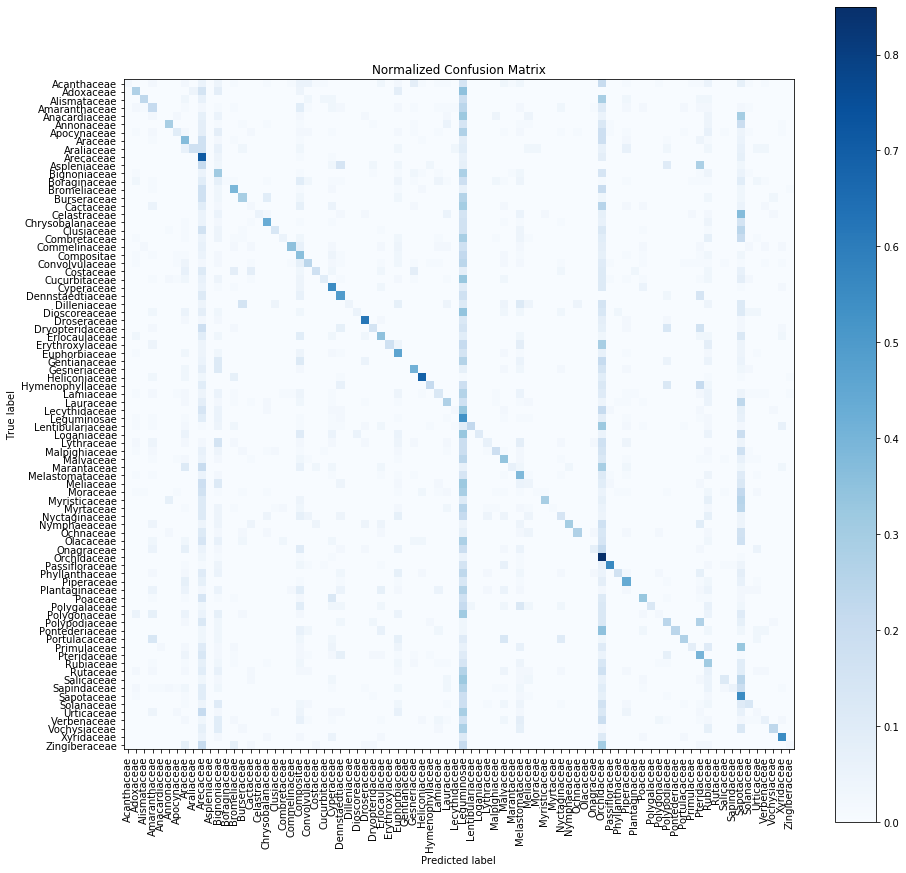

In [ ]:
scikitplot.metrics.plot_confusion_matrix(classes, predicted_classes, hide_counts=True, normalize=True, figsize=(15,15), x_tick_rotation=90);

In [ ]:
leguminosae_examples = test_metadata[classes == 'Leguminosae']
wrong_leguminosae_examples = test_metadata[(predicted_classes == 'Leguminosae') & (classes != 'Leguminosae')]

# True examples

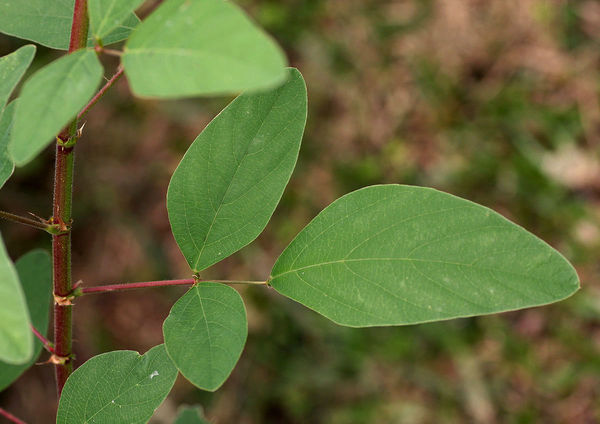

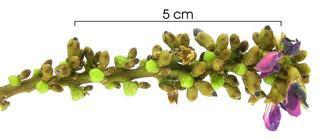

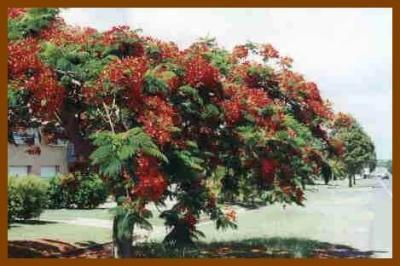

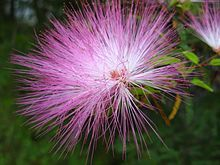

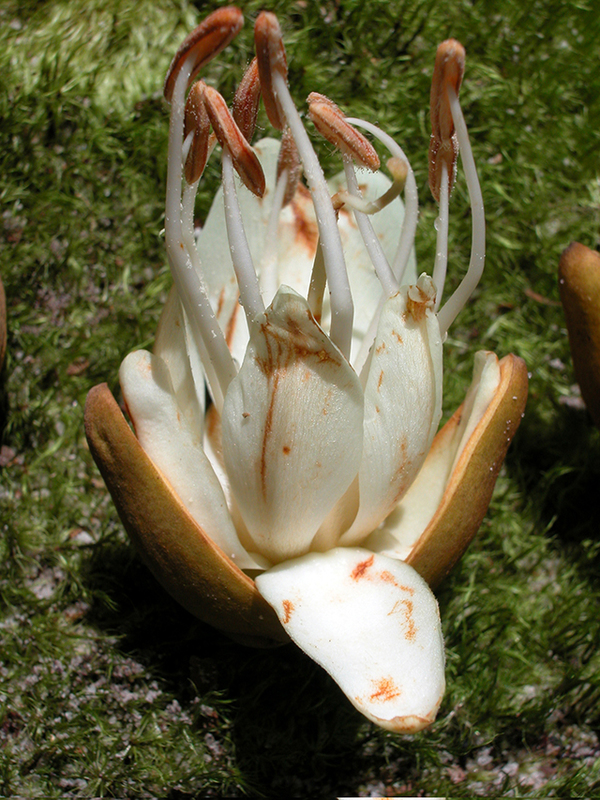

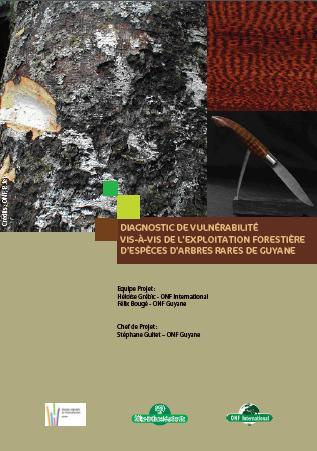

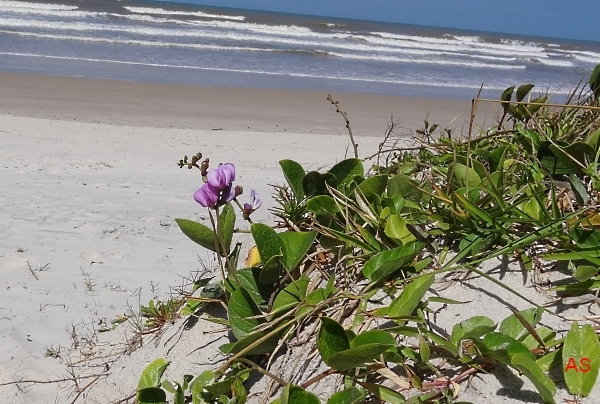

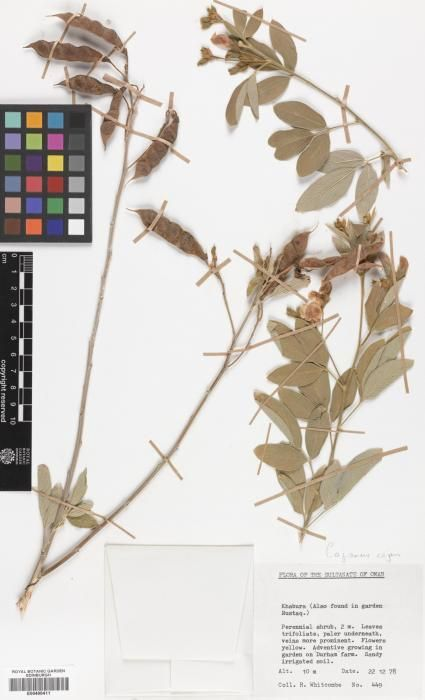

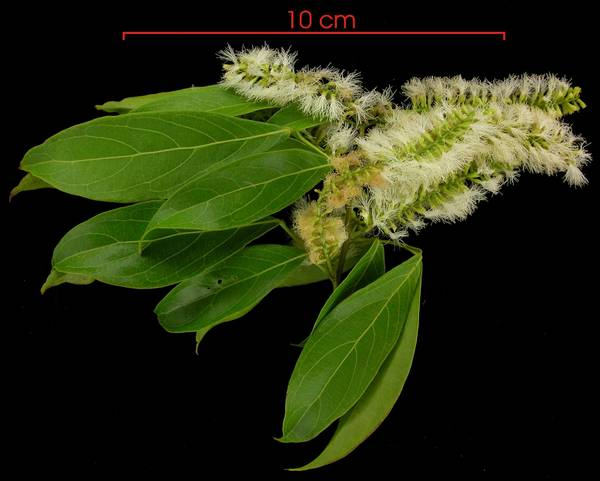

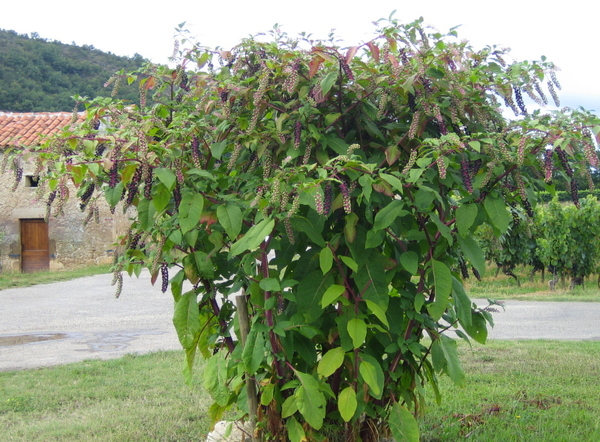

In [ ]:
for i in range(10):
    display(Image(leguminosae_examples['filename'].iloc[i]))

# False positives

Images predicted as *leguminosae* that are from a different class

As we see some images are from wildly different modalities: some of them are the plants themselves, while other are plant fruits, and even products made from plants.

correct class:  Poaceae


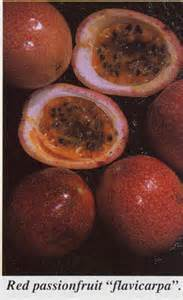

correct class:  Boraginaceae


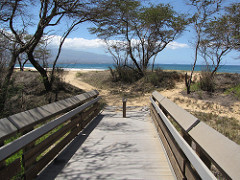

correct class:  Euphorbiaceae


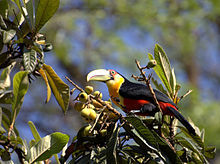

correct class:  Chrysobalanaceae


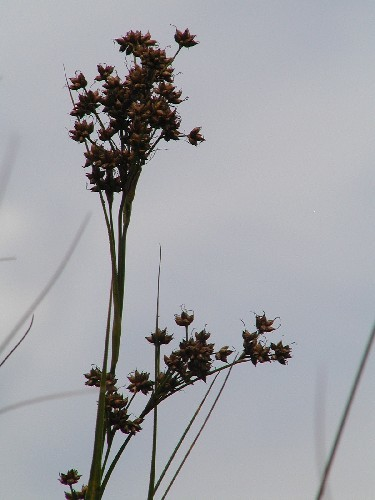

correct class:  Cyperaceae


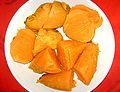

correct class:  Poaceae


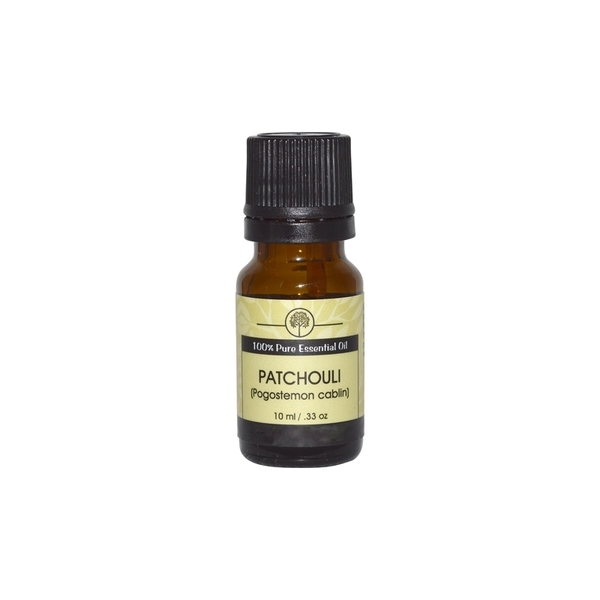

correct class:  Poaceae


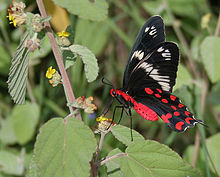

correct class:  Cyperaceae


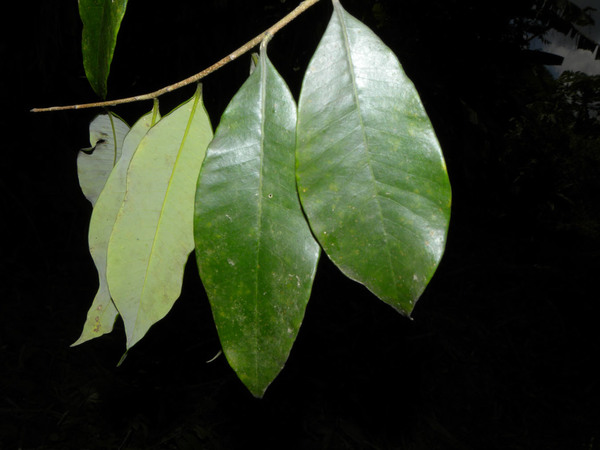

correct class:  Euphorbiaceae


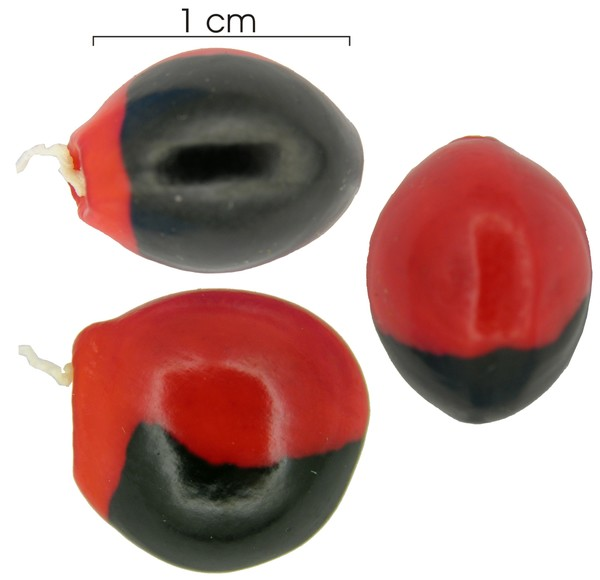

correct class:  Marantaceae


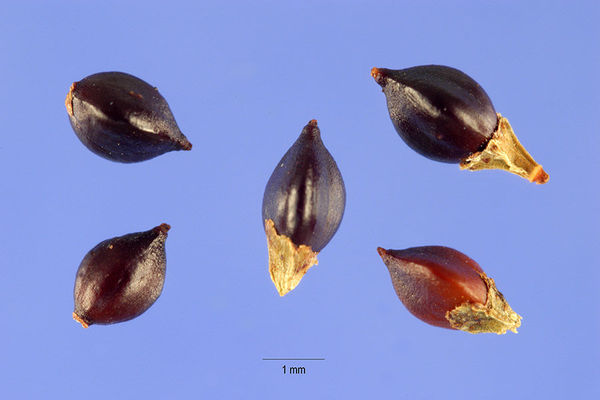

In [ ]:
for i in range(10):
    print('correct class: ', classes[i])
    display(Image(wrong_leguminosae_examples['filename'].iloc[i]))